### Copyright (c) 2018, Oracle and/or its affiliates. All rights reserved.

### Licensed under the Universal Permissive License v 1.0 as shown at http://oss.oracle.com/licenses/upl.

### How to deploy a vgg16 model for inference using GraphPipe

First, we download an image that we can use to test our model

In [1]:
img_path = "shepherd.jpg"
!wget -nc https://live.staticflickr.com/5645/19924112054_efe283d29c_q_d.jpg -O {img_path}

File ‘shepherd.jpg’ already there; not retrieving.


Next, we display the image:

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


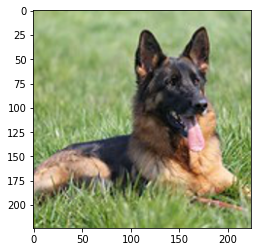

In [2]:
from tensorflow.python.keras.preprocessing import image
img = image.load_img(img_path, target_size=(224, 224), interpolation='bicubic')
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img)

Now we preprocess the image to make it ready for vgg. We convert the image
to an array and use the handy preprocess_input to do the standard vgg conversions.
Finally, we add a new axis to the dimension because we will be sending the image
in a batch of one to our model.

In [3]:
from tensorflow.python.keras.applications.vgg16 import preprocess_input
import numpy as np

x = image.img_to_array(img)
x = preprocess_input(x)
x = x[np.newaxis, :]
x.shape

(1, 224, 224, 3)

Next we instantiate the vgg16 model from the keras api using the pretrained imagenet weights

In [4]:
from tensorflow.python.keras.applications.vgg16 import VGG16

model = VGG16(weights="imagenet")
model.input.shape

TensorShape([None, 224, 224, 3])

The model correctly predicts our image as a german shepherd!

In [10]:
model.save("vgg.h5")

In [5]:
from tensorflow.python.keras.applications.vgg16 import decode_predictions

y = model.predict(x)
local_predictions = decode_predictions(y)
local_predictions[0][0]

('n02106662', 'German_shepherd', 0.97277075)

In order to use our model with the example graphpipe server, it must be saved
as a graphdef pb. There is some helper code in the examples directory to do
the conversion. **Note that you can also convert by running the script directly:
`./convert.py test.h5 test.pb`**

In [7]:
from convert import h5_to_pb
h5 = "test.h5"
pb = "test.pb"
port = 9000
model.save(h5)
model.save(pb)

INFO:tensorflow:Assets written to: test.pb/assets


In order to make requests and serve requests in the same notebook,
we have to serve the model in the background. In a regular script,
you could do something like `model_server.py --model test.pb`, but
in this case we'll be using the backgroundjobs lib. **Note that you
can't kill the background job once it has started, so you'll have to
restart the jupyter kernel if you want to change the model that you
are serving**

In [8]:
from IPython.lib import backgroundjobs as bg
from model_server import serve
jobs = bg.BackgroundJobManager()
jobs.new(serve, kw={"host": "", "port": 9000, "model": pb})

<BackgroundJob #0: <function serve at 0x1e8ae8b80>>

If something goes wrong, you can run the following cell to check
the traceback from the background job.

In [9]:
jobs.status()
jobs.traceback()

Dead jobs:
0 : <function serve at 0x1e8ae8b80>

Traceback for: <BackgroundJob #0: <function serve at 0x1e8ae8b80>>
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
/usr/local/lib/python3.9/site-packages/IPython/lib/backgroundjobs.py in call(self)
    489 
    490     def call(self):
--> 491         return self.func(*self.args, **self.kwargs)

~/hacking/graphpipe-tf-py/examples/model_server.py in serve(host, port, model)
     22 def serve(host, port, model):
     23     with tf.Graph().as_default() as graph:
---> 24         graph_def = tf.GraphDef()
     25         with tf.gfile.GFile(model, "rb") as f:
     26             graph_def.ParseFromString(f.read())

AttributeError: module 'tensorflow' has no attribute 'GraphDef'



Let's try doing a prediction using the remote model. If we omit
the input and output names, it uses the first and last operation
in the model. **Note that if you want to retrieve output from a
different layer of the model, the operation name is prefixed with
"import/", so if you wanted the output of the last fully connected
layer instead of the predictions, you could add
`output_name="import/fc2/Relu"` to the call to `remote.execute`**

In [16]:
from graphpipe import remote
y = remote.execute("http://127.0.0.1:9000", x)
remote_predictions = decode_predictions(y)

Finally, we verify that the remote predictions are the same as those given by the local model

In [13]:
remote_predictions == local_predictions

False

In [17]:
remote_predictions

[[('n02106662', 'German_shepherd', 0.97277075),
  ('n02105162', 'malinois', 0.023473518),
  ('n04254680', 'soccer_ball', 0.0006082931),
  ('n02105412', 'kelpie', 0.0005825574),
  ('n03803284', 'muzzle', 0.00045637542)]]

In [15]:
local_predictions

[[('n02106662', 'German_shepherd', 0.97277075),
  ('n02105162', 'malinois', 0.023473518),
  ('n04254680', 'soccer_ball', 0.0006082931),
  ('n02105412', 'kelpie', 0.0005825574),
  ('n03803284', 'muzzle', 0.00045637542)]]